# **0. Setup**

## 0.1. Library and Environment

In [ ]:
# !pip -U install pandas matplotlib yfinance seaborn plotly alpha_vantage python-dotenv nbformat statsmodels scikit-learn


Usage:   
  pip <command> [options]

no such option: -U


In [ ]:
import os
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dotenv import load_dotenv # type: ignore
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"

## 0.2. Data downloading

In [84]:
aug_data = pd.read_csv("data/v5.csv", index_col=0)

# **1. EDA**

## a. Data Summary

In [85]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3518 entries, 0 to 3517
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3518 non-null   object 
 1   Open         3518 non-null   float64
 2   High         3518 non-null   float64
 3   Low          3518 non-null   float64
 4   Close        3518 non-null   float64
 5   Volume       3518 non-null   int64  
 6   VIX          3518 non-null   float64
 7   US10Y        3518 non-null   float64
 8   DXY          3518 non-null   float64
 9   OIL          3518 non-null   float64
 10  GOLD         3518 non-null   float64
 11  CPI_US       3518 non-null   float64
 12  MA_20        3518 non-null   float64
 13  EMA_20       3518 non-null   float64
 14  MAE_20       3518 non-null   float64
 15  MA_60        3518 non-null   float64
 16  EMA_60       3518 non-null   float64
 17  MAE_60       3518 non-null   float64
 18  MA_120       3518 non-null   float64
 19  EMA_120    

In [87]:
print(f"Null value check: \n{aug_data.isna().sum()}")

Null value check: 
Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
VIX            0
US10Y          0
DXY            0
OIL            0
GOLD           0
CPI_US         0
MA_20          0
EMA_20         0
MAE_20         0
MA_60          0
EMA_60         0
MAE_60         0
MA_120         0
EMA_120        0
MAE_120        0
MA_360         0
EMA_360        0
MAE_360        0
MACD           0
MACD_long      0
Signal         0
Signal_long    0
RSI_7          0
RSI_14         0
RSI_28         0
RSI_56         0
dtype: int64


In [88]:
duplicate_count = aug_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


## b. Statistical Analysis

In [89]:
data = aug_data.copy()

def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include=['number']).columns
})
stats_summary

,Open,High,Low,Close,Volume,VIX,US10Y,DXY,OIL,GOLD,CPI_US,MA_20,EMA_20,MAE_20,MA_60,EMA_60,MAE_60,MA_120,EMA_120,MAE_120,MA_360,EMA_360,MAE_360,MACD,MACD_long,Signal,Signal_long,RSI_7,RSI_14,RSI_28,RSI_56
mean,416.459915,419.610855,413.316316,416.580211,1.197605e+08,25.289144,105.360025,25.017769,35.072762,148.542763,26.580698,414.966987,414.952079,3.721269,411.458288,411.563439,3.700360,406.576574,406.889095,3.669890,389.969796,391.248799,3.604618,1.215616,4.674345,1.221636,4.497438,54.519207,54.383979,54.048229,53.565418
median,406.690002,410.020004,403.309998,406.745010,4.748800e+06,20.470000,105.330000,25.060000,33.615000,143.880000,26.592500,405.914249,406.050263,3.040243,403.902667,404.316265,3.134418,401.433917,406.148377,3.198917,391.161042,397.452659,2.793834,1.486598,4.074653,1.466118,4.068069,54.871884,54.428400,54.347001,53.651690
std,156.521521,157.565916,155.479851,156.526060,1.629818e+08,17.136061,7.295446,2.383741,22.894994,31.642322,0.872154,155.198624,155.028135,2.481358,152.335559,152.175074,2.126325,148.997245,148.740057,1.911879,139.863559,140.068571,1.657025,6.036312,11.229062,5.651588,10.349887,22.755735,16.284104,11.289183,7.806017
min,151.729996,158.000000,147.660004,153.899994,0.000000e+00,5.250000,88.950000,20.930000,2.130000,100.500000,23.919900,162.902000,163.194174,0.619501,169.174833,172.083540,1.231834,172.688666,177.768672,1.410250,192.139167,191.193539,1.675583,-47.619195,-31.174432,-41.028616,-25.386829,0.000000,2.186875,21.404229,29.465601
max,854.250000,857.109985,851.289978,851.979980,1.335046e+09,121.950000,123.060000,30.670000,91.990000,257.500000,28.520000,835.313501,830.505641,24.299998,806.952665,802.998564,14.902166,769.021499,774.446570,10.773832,674.711943,698.742249,7.110110,18.004074,36.935660,16.728409,34.841029,100.000000,96.628614,85.733906,76.278294
q1,297.874992,299.687508,295.830002,297.967506,0.000000e+00,14.050000,101.270000,22.710000,12.740000,121.332500,25.890000,297.001375,296.699491,2.053999,295.947127,296.945605,2.084501,296.267418,296.460104,2.170229,276.167223,275.184642,2.399632,-1.243367,-0.311478,-0.960669,-0.745924,37.601945,43.065670,46.147471,48.649747
q3,537.517517,543.132507,533.512482,537.649994,2.544945e+08,29.545000,109.300000,26.470000,47.795000,169.505000,27.344850,539.542501,540.549710,4.767378,546.192373,546.998772,4.892749,548.107376,552.929139,4.807166,468.332764,505.664467,5.228770,4.166297,9.681235,3.857002,9.171006,71.842171,66.224710,62.215228,58.705930
iqr,239.642525,243.445000,237.682480,239.682487,2.544945e+08,15.495000,8.030000,3.760000,35.055000,48.172500,1.454850,242.541126,243.850219,2.713379,250.245247,250.053167,2.808249,251.839958,256.469035,2.636937,192.165542,230.479825,2.829137,5.409664,9.992713,4.817672,9.916930,34.240226,23.159041,16.067757,10.056184


## c. Visualization

### c.1. Candlestick Chart

In [90]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data['Date'],
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=0.4
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='S&P 500 Financials (Sector) (^SP500-40)',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Index',
    xaxis_rangeslider_visible=False,
    template='seaborn',
    width=2000,
    height=600,
)

fig.show()

### c.2. Boxplot

/tmp/ipykernel_709852/3793571005.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_709852/3793571005.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




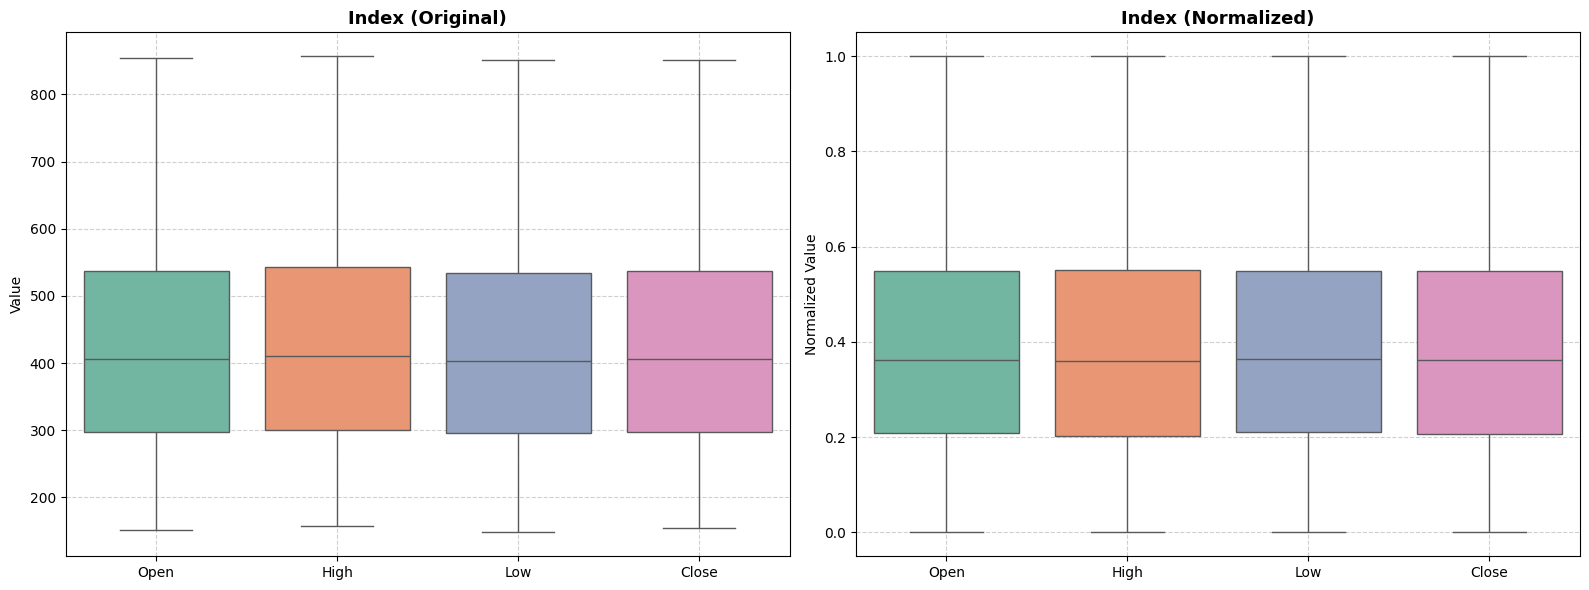

/tmp/ipykernel_709852/3793571005.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_709852/3793571005.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




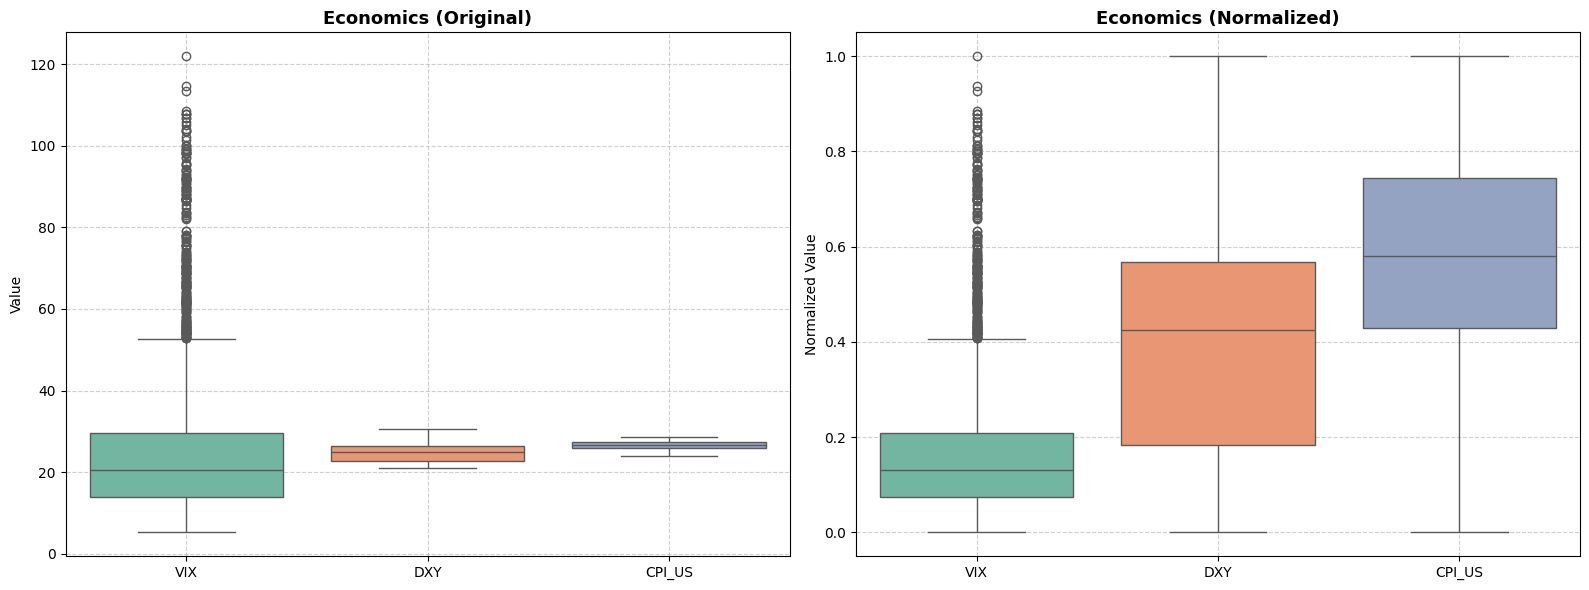

/tmp/ipykernel_709852/3793571005.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_709852/3793571005.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




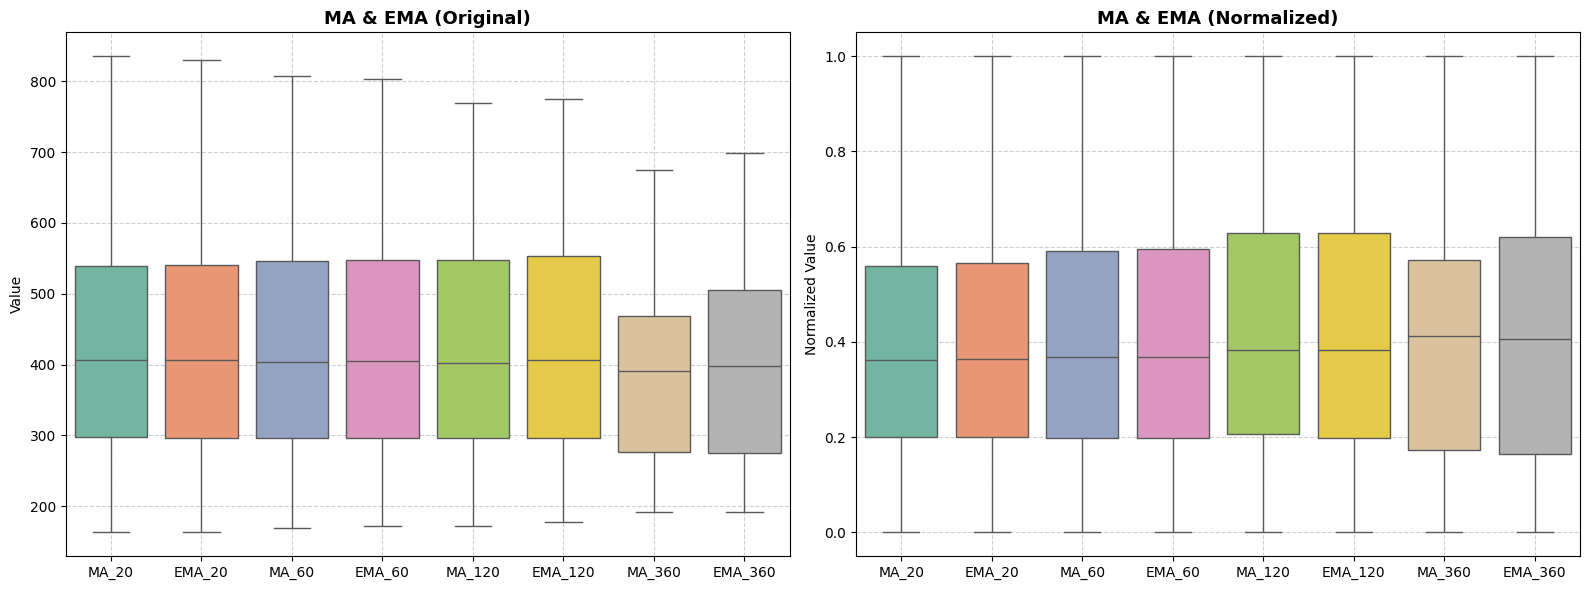

/tmp/ipykernel_709852/3793571005.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_709852/3793571005.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




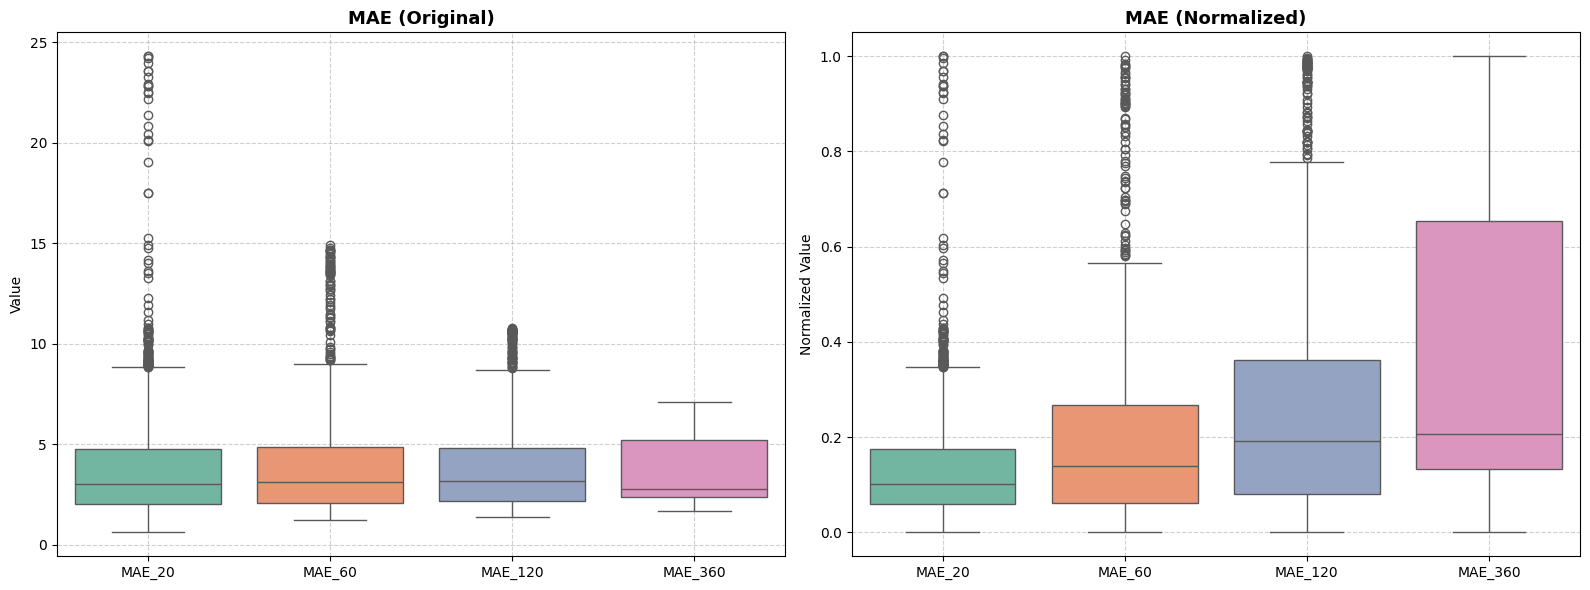

/tmp/ipykernel_709852/3793571005.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_709852/3793571005.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




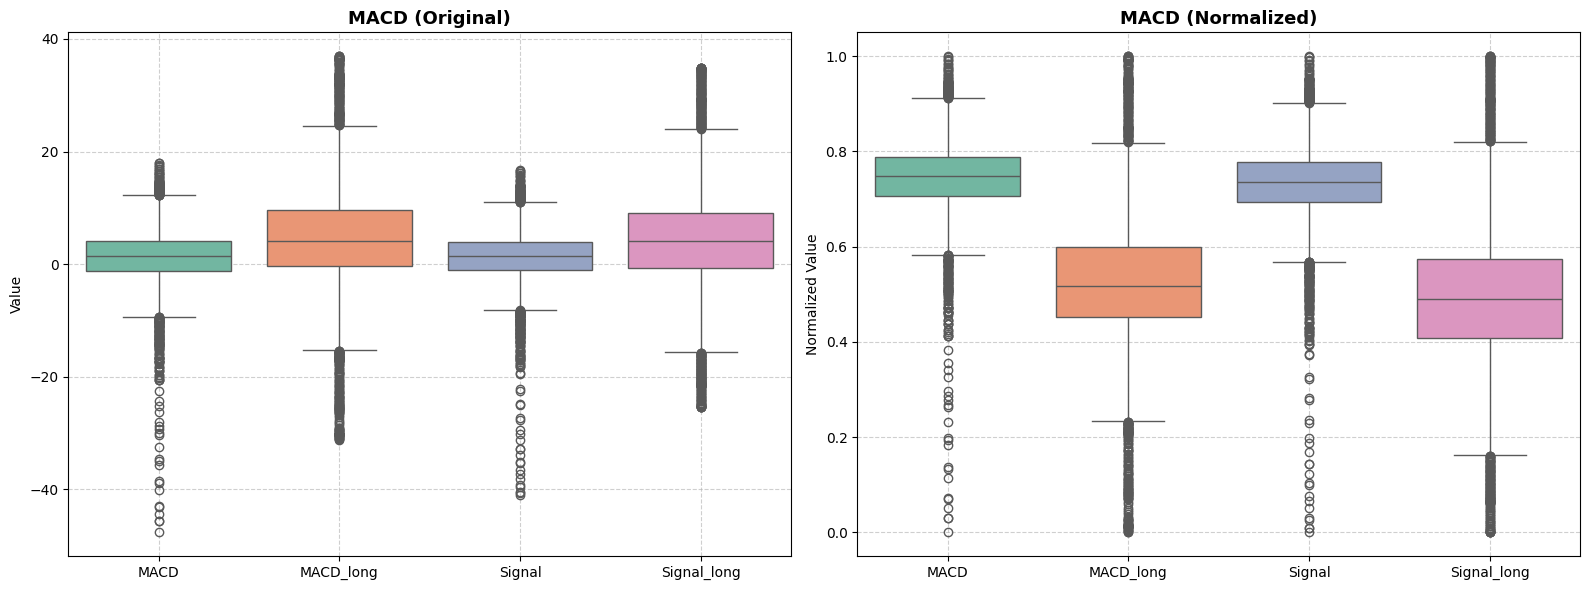

/tmp/ipykernel_709852/3793571005.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_709852/3793571005.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




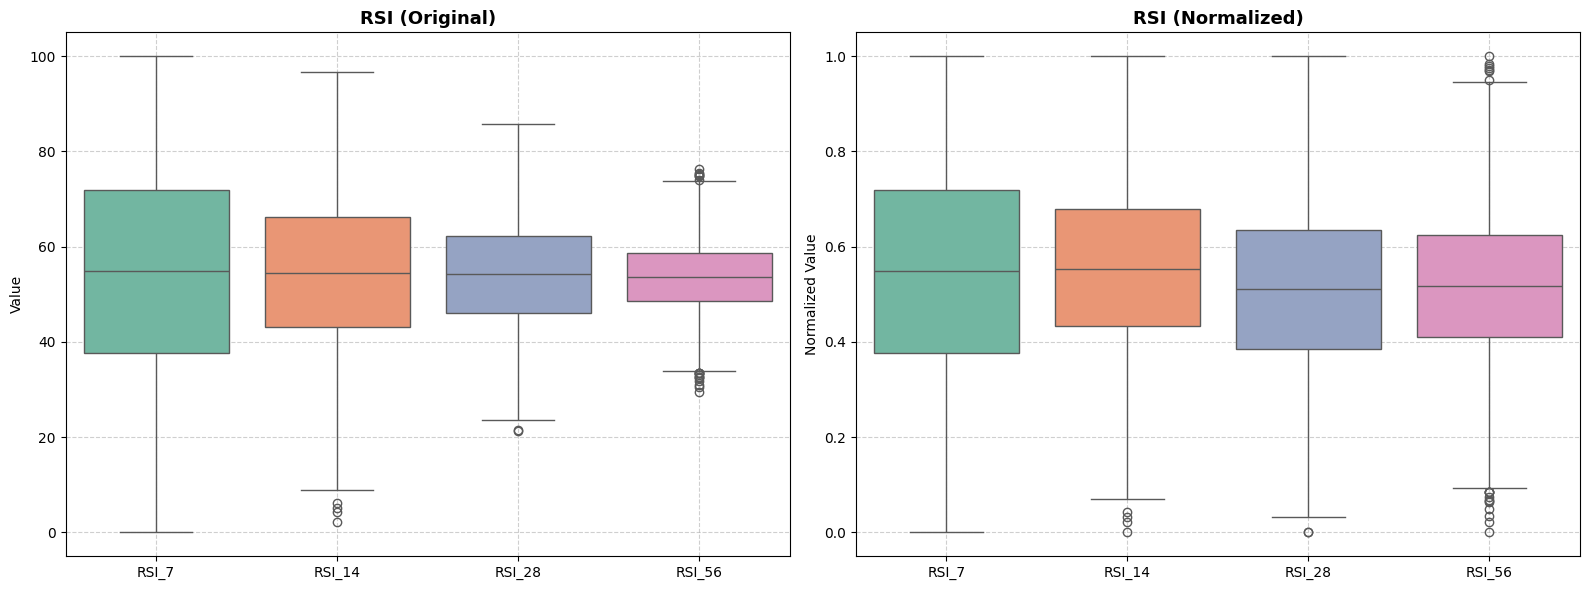

In [83]:
groups = {
    # "Volume": ["Volume"],
    "Index": ["Open", "High", "Low", "Close"],
    'Economics': [ 'VIX', 'DXY', 'CPI_US'],
    "MA & EMA": ['MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120', 'MA_360', 'EMA_360'],
    "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    "RSI": ['RSI_7', 'RSI_14', 'RSI_28', 'RSI_56']
}

for title, cols_in_group in groups.items():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    data_melted = data.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        x="Value Type",
        y="Value",
        data=data_melted,
        palette="Set2",
        order=cols_in_group,
        ax=axes[0]
    )
    axes[0].set_title(f"{title} (Original)", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Value")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    scaler = MinMaxScaler()
    data_norm = data[cols_in_group].copy()
    data_norm = pd.DataFrame(
        scaler.fit_transform(data_norm),
        columns=cols_in_group,
        index=data.index
    )
    data_norm_melted = data_norm.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        x="Value Type",
        y="Value",
        data=data_norm_melted,
        palette="Set2",
        order=cols_in_group,
        ax=axes[1]
    )
    axes[1].set_title(f"{title} (Normalized)", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Normalized Value")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    save_path = os.path.join(FIG_DIR, f"boxplot_{title.replace(' ', '_')}_compare.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.3. Histogram

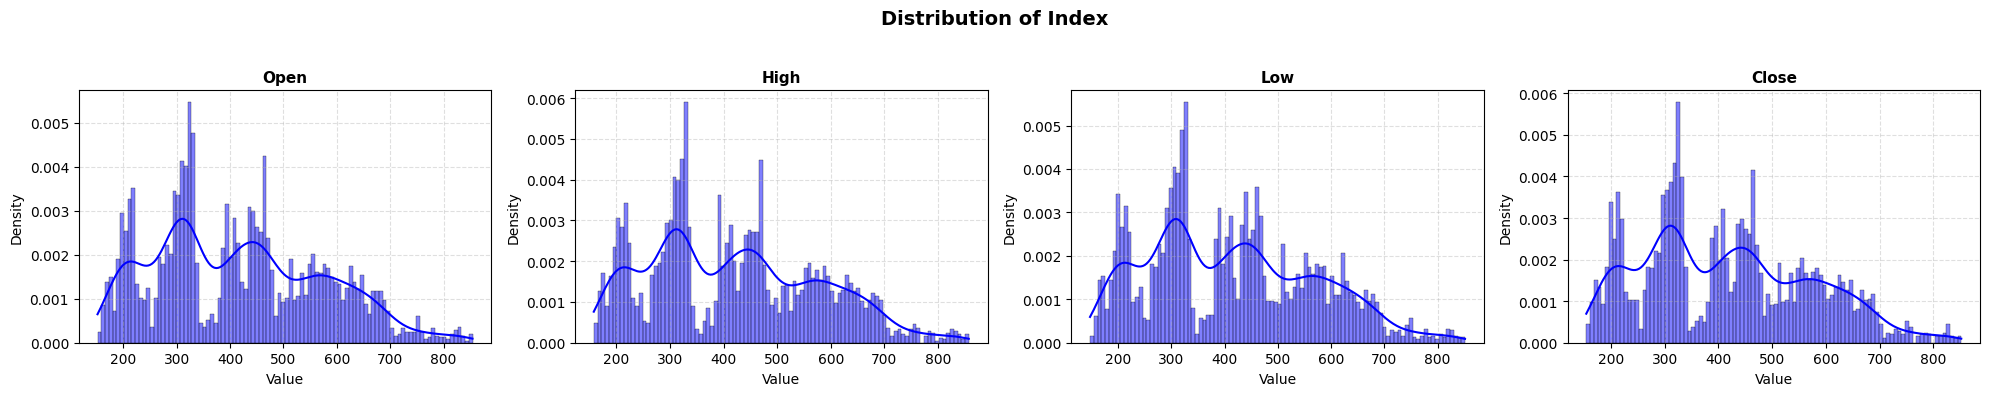

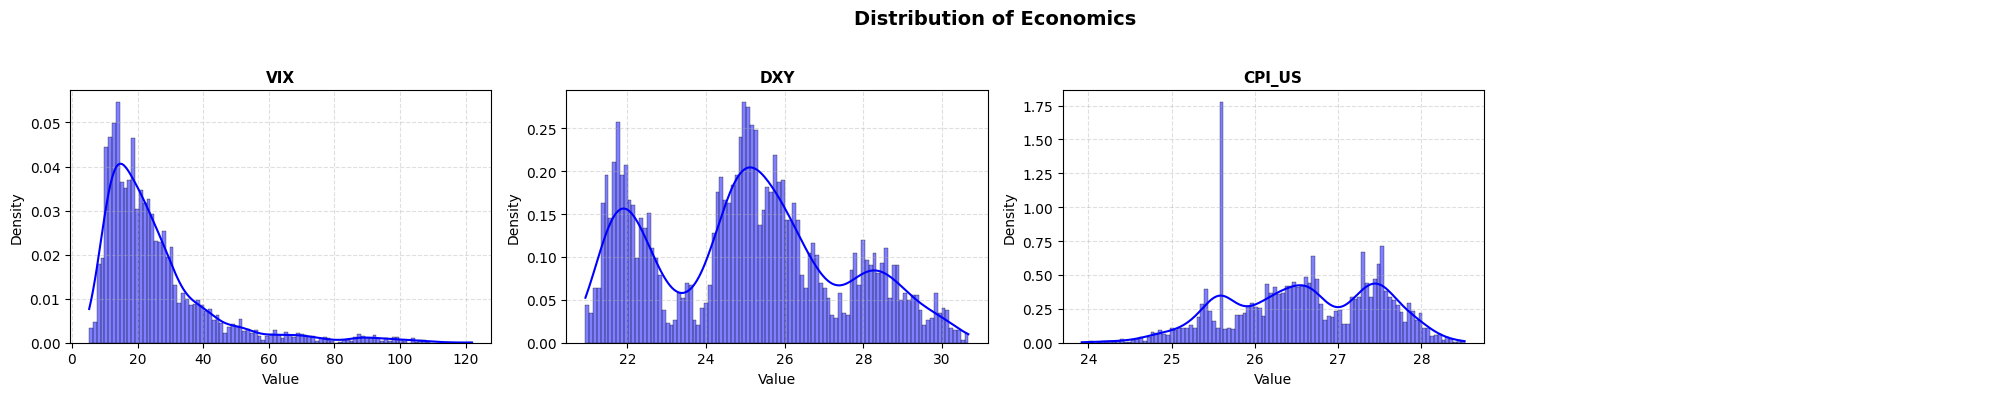

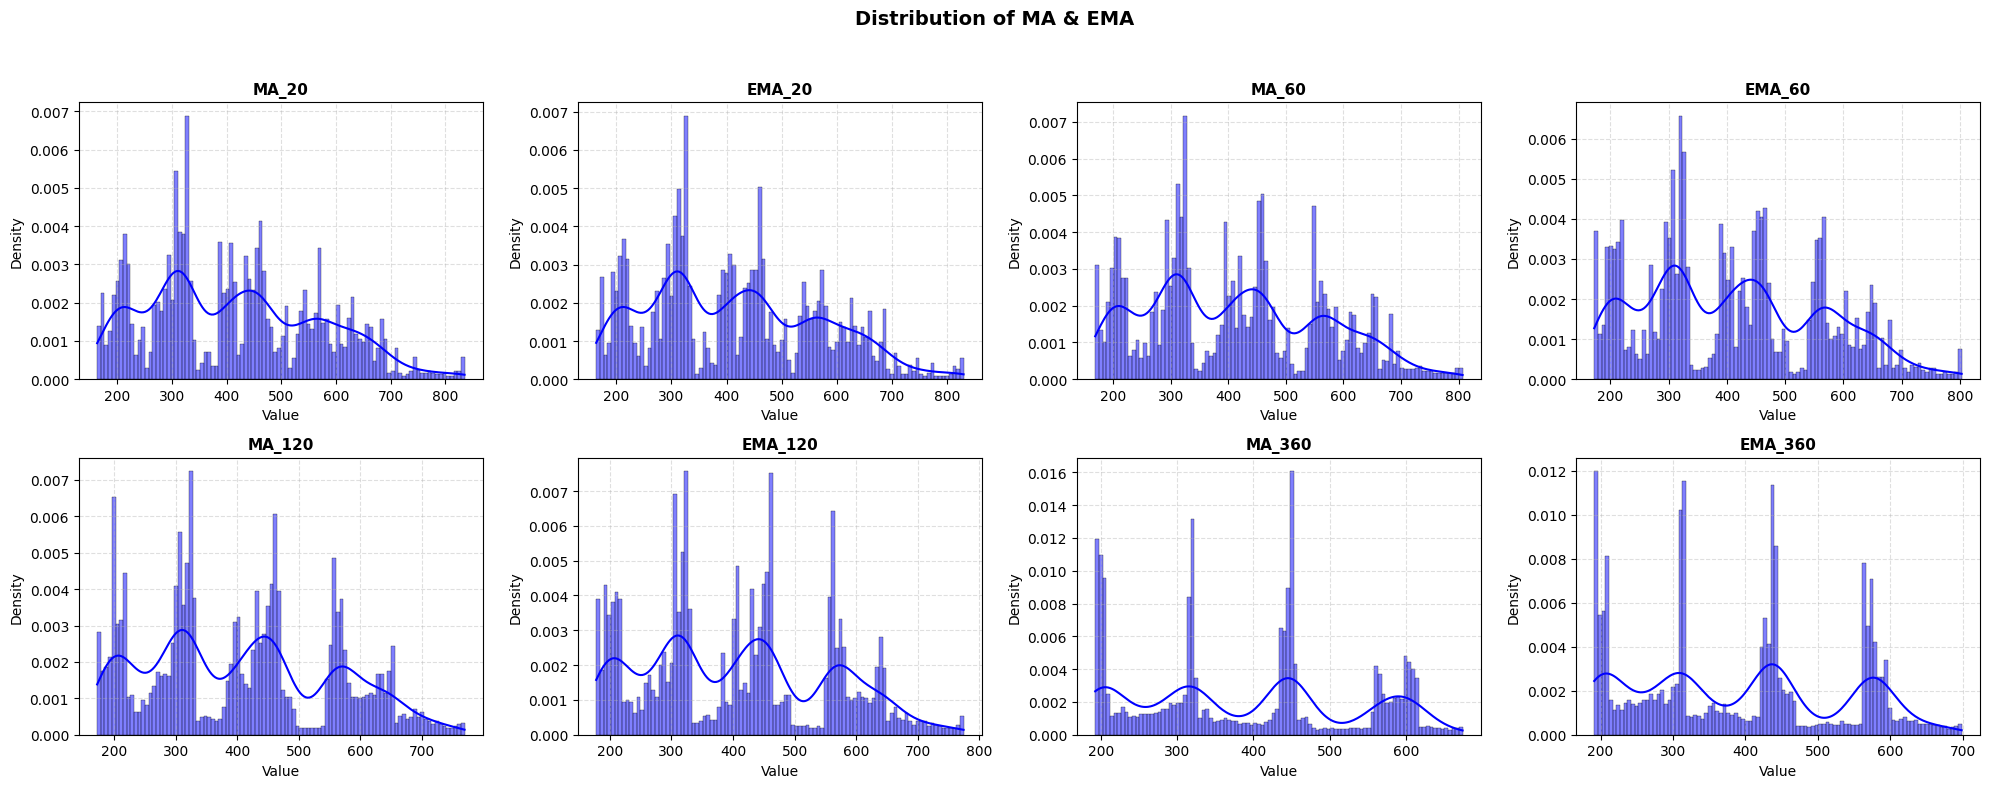

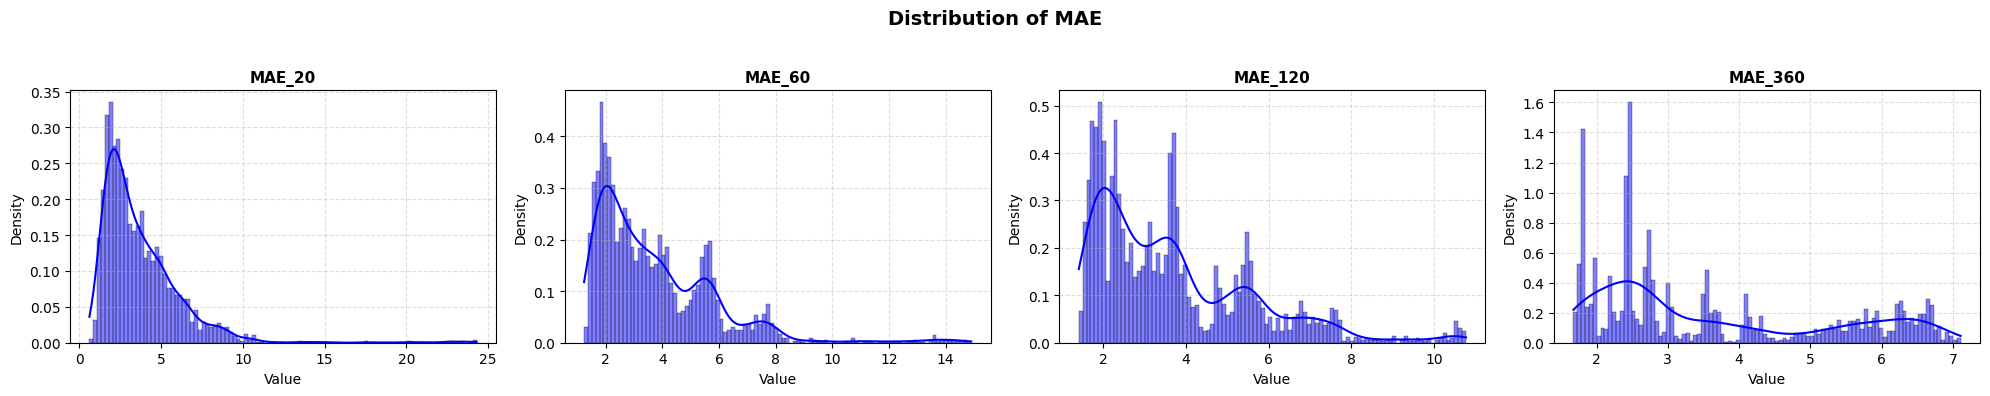

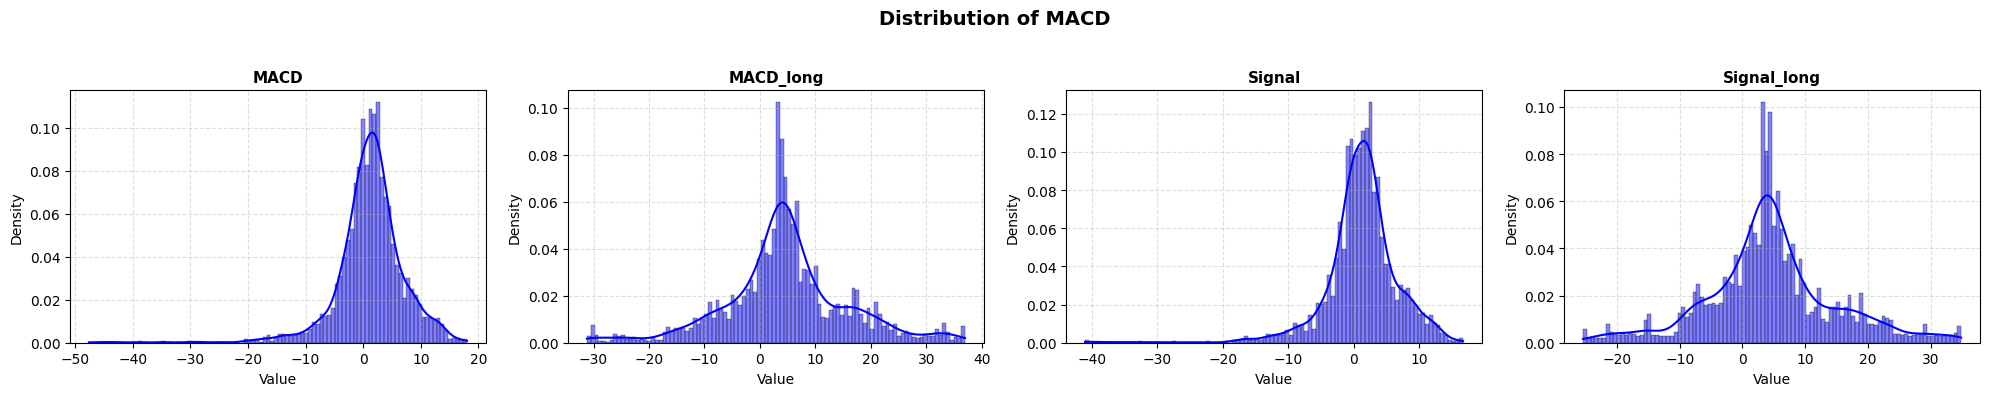

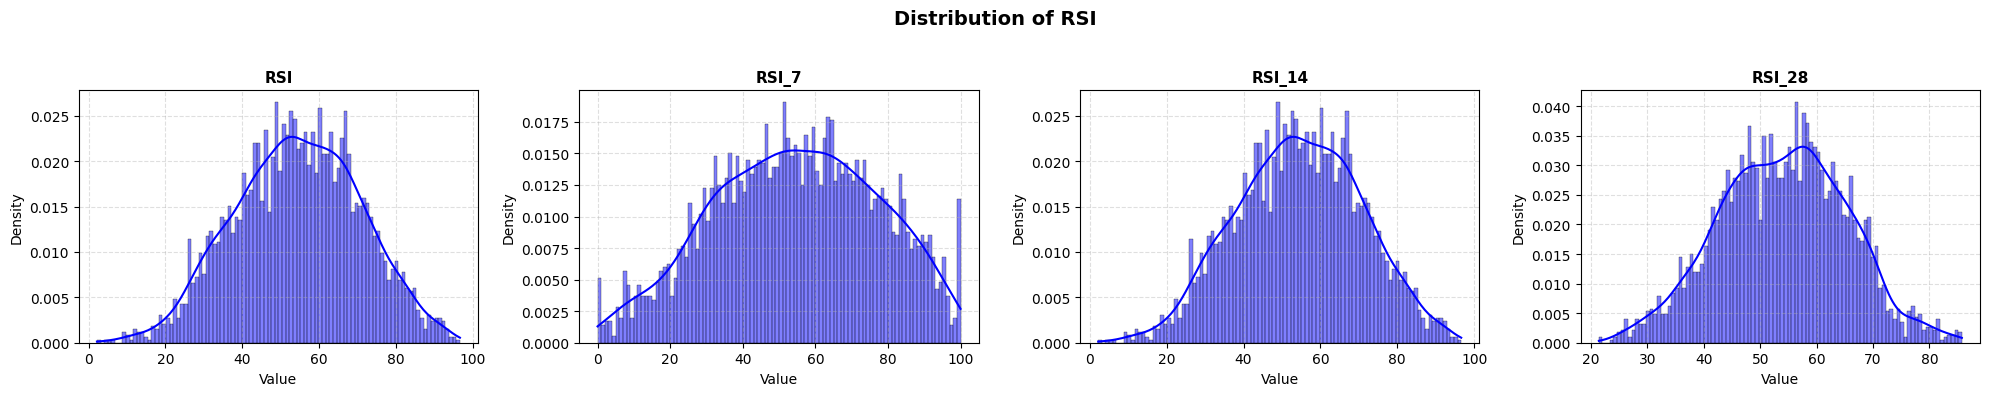

In [65]:
max_cols = 4

for title, cols_in_group in groups.items():
    n = len(cols_in_group)
    n_rows = math.ceil(n / max_cols)

    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5*max_cols, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_in_group):
        sns.histplot(
            data[col].dropna(),
            kde=True,
            stat="density",
            bins=100,
            color="blue",
            ax=axes[i]
        )
        axes[i].set_title(f"{col}", fontsize=11, fontweight='bold')
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Density")
        axes[i].grid(True, linestyle="--", alpha=0.4)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Distribution of {title}", fontsize=14, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    save_path = os.path.join(FIG_DIR, f"group_hist_{title.replace(' ', '_')}.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.4. Line Chart

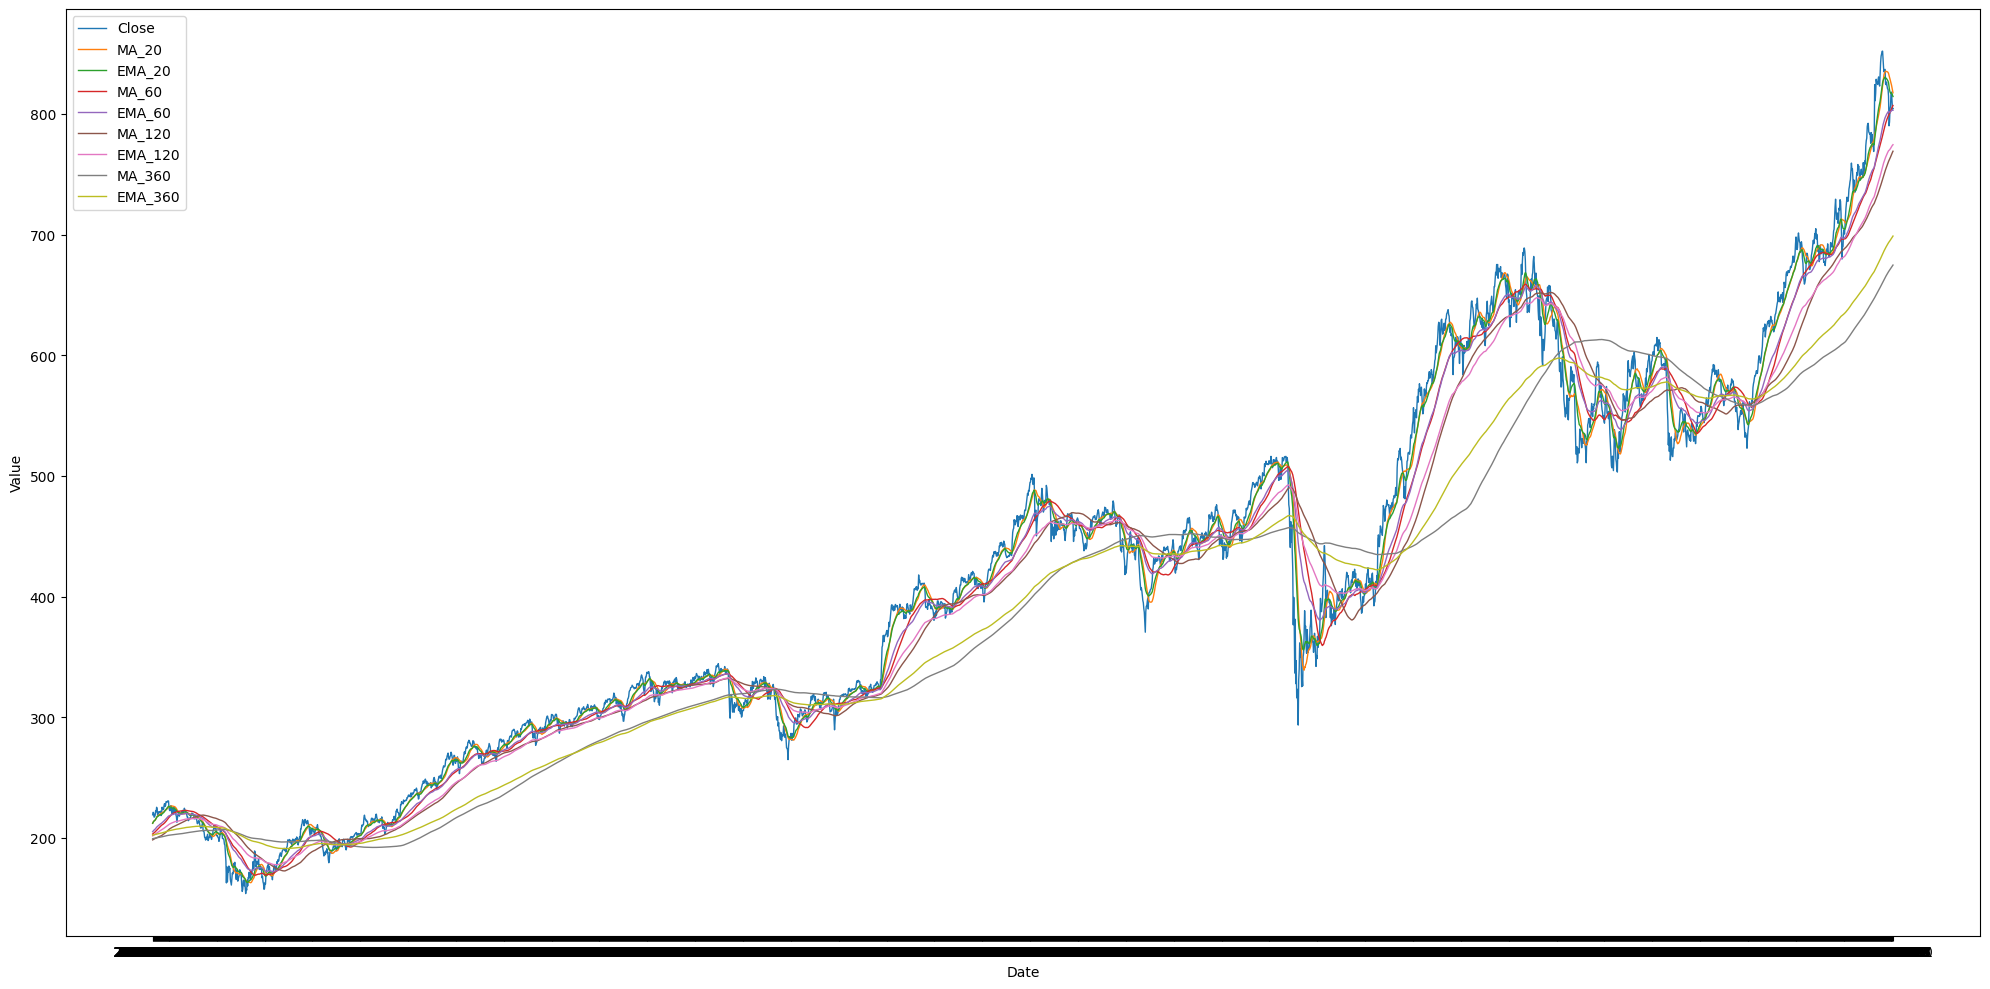

In [91]:
groups = {
    # 'Kinh te': ['DXY', 'CPI_US'],
    "MA & EMA": ["Close", 'MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120', 'MA_360', 'EMA_360'],
    # "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    # "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    # "RSI": ['RSI', 'RSI_7', 'RSI_14', 'RSI_28']
}

plt.figure(figsize=(20,10))

for title, cols_in_group in groups.items():
    for col in cols_in_group:
        plt.plot(data["Date"], data[col], label=f"{col}", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
# line_path = os.path.join(FIG_DIR, "line_trend.png")
# plt.savefig(line_path, dpi=150)
plt.close()

### c.5. Heatmap

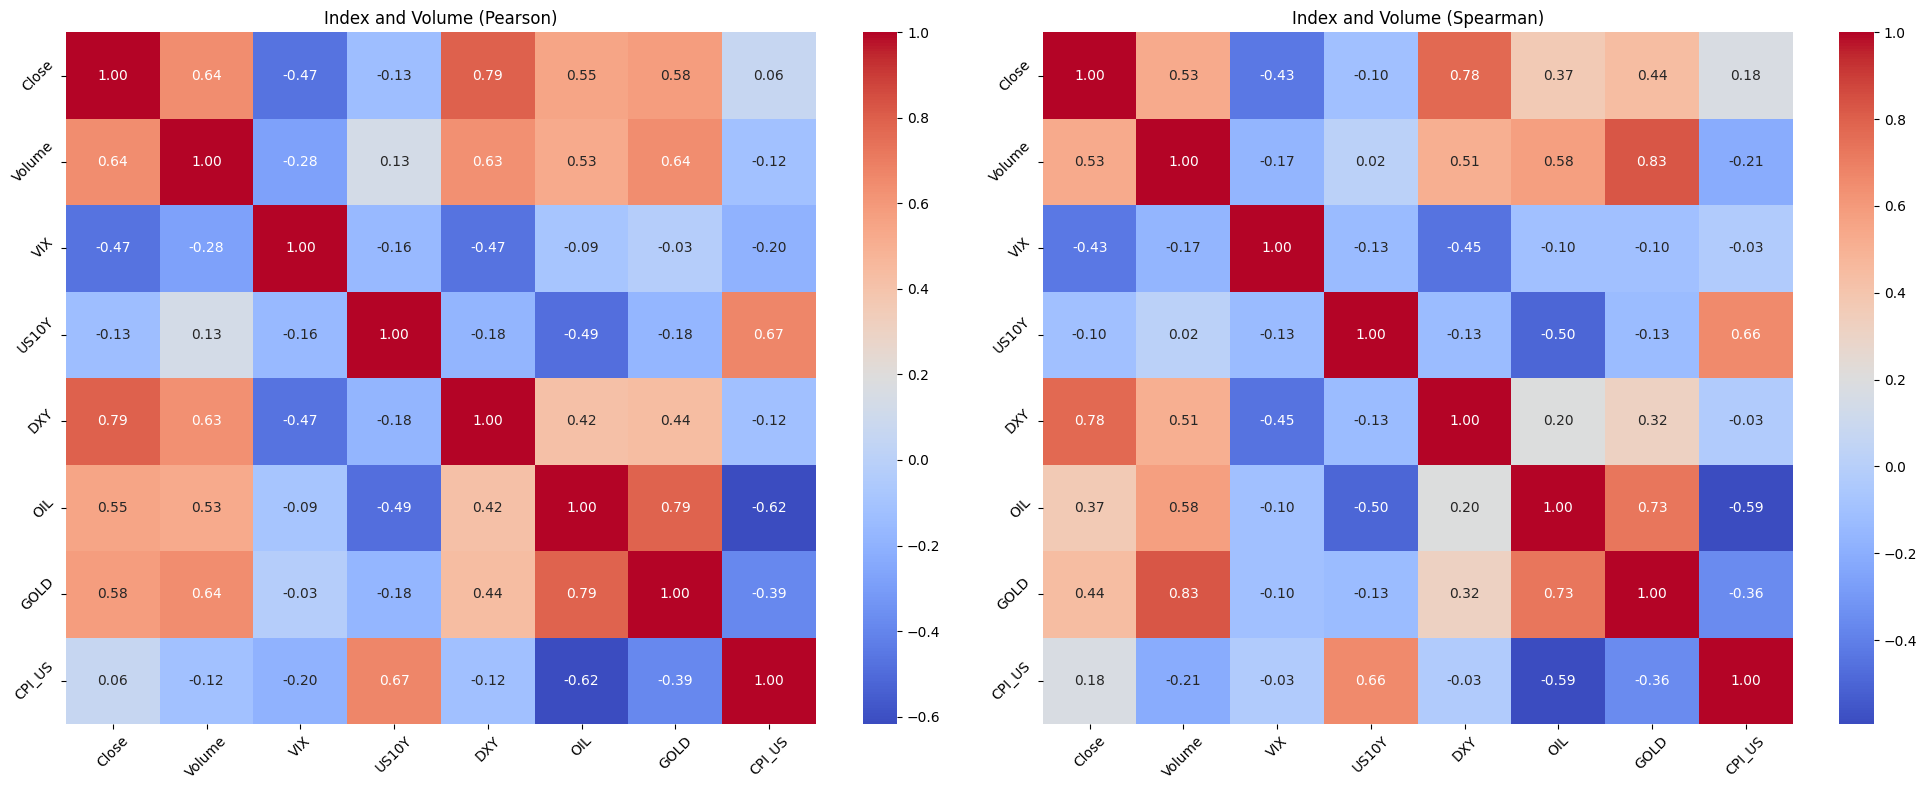

In [ ]:
corr_pear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD', "CPI_US"
    ]
].corr(method="pearson")

corr_spear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD', "CPI_US"
    ]
].corr(method="spearman")

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Spearman)")

plt.tight_layout()
plt.show()

## d. Anomaly detection

## e. Dataset overall review

# **2. Probability distribution analysis**

# **3. Hypothesis Testing**

# **4. Correlation Analysis**

# **5. Multiple Linear Regression**